In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Data Retrieving
#data_path = D:\Downloads D Drive\IBM project1_supervised ML_regression_insurance charge prediction
#filepath = os.sep.join(data_path + ['insurance.csv'])
data = pd.read_csv('insurance.csv', sep=',')
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [5]:
# num of rows x num of columns
print('Dataset Dimensions:',data.shape)
print("---------------------------------")
# types of each column
print(data.dtypes)

Dataset Dimensions: (1338, 7)
---------------------------------
age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object


In [6]:
data.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [7]:
data.isnull().sum()

,0
age,0
sex,0
bmi,0
children,0
smoker,0
region,0
charges,0


In [ ]:
#no missing values, so this is good

2- Converting categorical features into numerical features



In [9]:
# Select the object (string) columns
mask = data.dtypes == object
categorical_cols = data.columns[mask]
categorical_cols

Index(['sex', 'smoker', 'region'], dtype='object')

In [10]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for category in categorical_cols:
    le.fit(data[category].drop_duplicates())
    data[category] = le.transform(data[category])

In [11]:
data.head(10)

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520
5,31,0,25.740,0,0,2,3756.62160
6,46,0,33.440,1,0,2,8240.58960
7,37,0,27.740,3,0,1,7281.50560
8,37,1,29.830,2,0,0,6406.41070
9,60,0,25.840,0,0,1,28923.13692


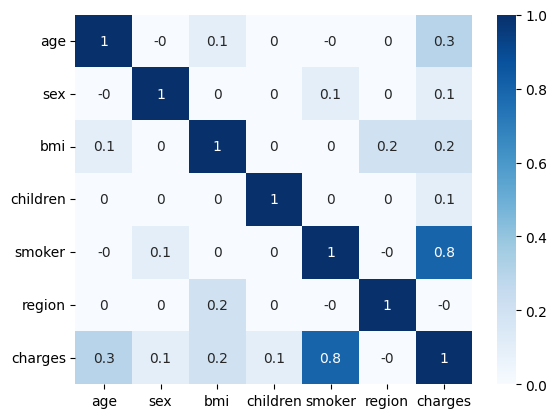

In [12]:
# Studying the corellations between features using Heat Map!
plt.figure(dpi=100)
sns.heatmap(np.round(data.corr(),1),annot=True, cmap="Blues")
plt.show()

In [13]:
# sorting features according to the strength of corretlation with charges feature
data.corr()['charges'].sort_values(ascending = False)

,charges
charges,1.000000
smoker,0.787251
age,0.299008
bmi,0.198341
children,0.067998
sex,0.057292
region,-0.006208


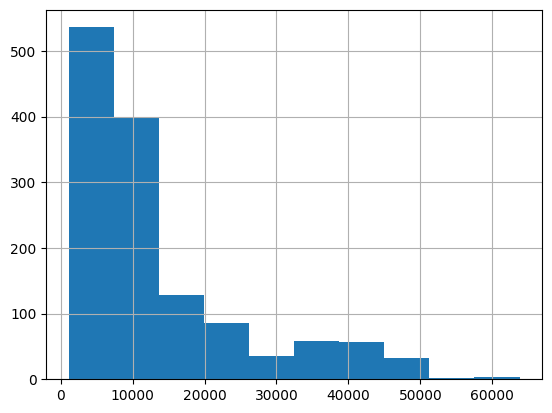

In [14]:
data.charges.hist();


In [15]:
# applying D'Agostino K^2 test to check the normality!
from scipy.stats.mstats import normaltest # D'Agostino K^2 Test
normaltest(data.charges.values)

NormaltestResult(statistic=np.float64(336.8851220567733), pvalue=np.float64(7.019807901276197e-74))

In [ ]:
#so, it's not normalized data

NormaltestResult(statistic=np.float64(112.4605295472106), pvalue=np.float64(3.7975744156203163e-25))

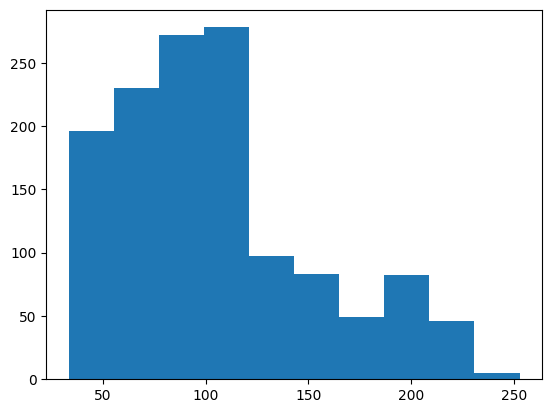

In [16]:
# applying log transform on chareges feature:
sqrt_charges = np.sqrt(data.charges)
plt.hist(sqrt_charges)

# applying D'Agostino K^2 test to check the normality!
sqrt_test_res = normaltest(sqrt_charges.values)
sqrt_test_res

NormaltestResult(statistic=np.float64(52.71670509113935), pvalue=np.float64(3.5703676381337117e-12))

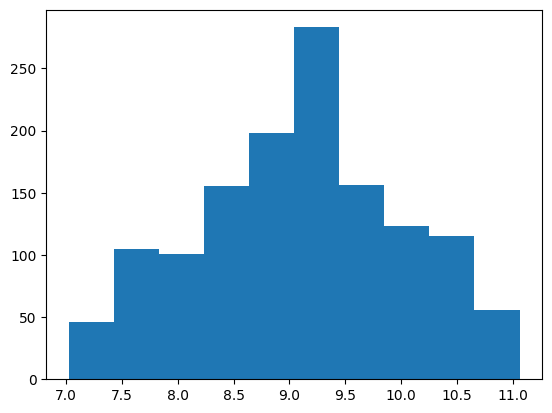

In [17]:
# applying log transform on chareges feature:
log_charges = np.log(data.charges)
plt.hist(log_charges)

# applying D'Agostino K^2 test to check the normality!
log_test_res = normaltest(log_charges.values)
log_test_res

In [19]:
from scipy.stats import boxcox

In [20]:
# applying box cox transform on change feature:
bc_result = boxcox(data.charges)
boxcox_medv = bc_result[0]
lam = bc_result[1]

NormaltestResult(statistic=np.float64(54.41810197267635), pvalue=np.float64(1.524962972734298e-12))

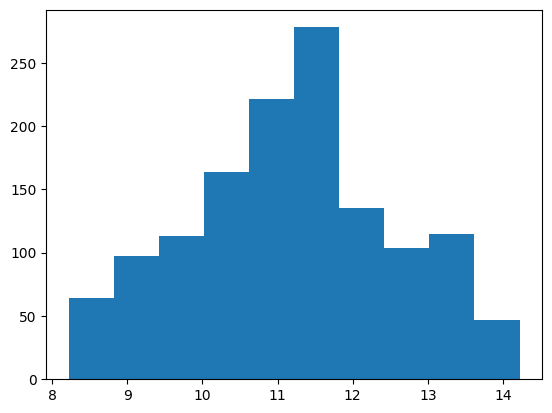

In [21]:
plt.hist(boxcox_medv)
boxcox_test_res= normaltest(boxcox_medv)
boxcox_test_res

In [22]:
d = {'Transormation': ['Square-Root', 'Log', 'Box Cox' ], 'P-value': [sqrt_test_res[1], log_test_res[1], boxcox_test_res[1]]}
df_results = pd.DataFrame(data=d)
df_results

,Transormation,P-value
0,Square-Root,3.797574e-25
1,Log,3.570368e-12
2,Box Cox,1.524963e-12


# **Applying Various Regression Models**

In [23]:
# Importing Libraries
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [25]:
insurance_data = data

# Select the object (string) columns
mask = insurance_data.dtypes == object
categorical_cols = insurance_data.columns[mask]

# convert categorical data into numerical data
le = LabelEncoder()
for category in categorical_cols:
    le.fit(insurance_data[category].drop_duplicates())
    insurance_data[category] = le.transform(insurance_data[category])

X = insurance_data.drop(['charges','region'], axis=1)
y = insurance_data.charges

pf = PolynomialFeatures(degree=2, include_bias=False)
X_pf = pf.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_pf, y,
                                                    test_size=0.3, random_state=42)

In [26]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import KFold, cross_val_predict, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline

In [28]:
# Data Retrieving
insurance_data = pd.read_csv('insurance.csv')
insurance_data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [30]:
# Select the object (string) columns
mask = insurance_data.dtypes == object
categorical_cols = insurance_data.columns[mask]

le = LabelEncoder()
for category in categorical_cols:
    le.fit(insurance_data[category].drop_duplicates())
    insurance_data[category] = le.transform(insurance_data[category])

X = insurance_data.drop(['charges','region'], axis=1)
y = insurance_data.charges

# create folds
kf = KFold(shuffle=True, random_state=42, n_splits=3)

In [31]:
#1: Baseline linear regression
estimator = Pipeline([("scaler", StandardScaler()),
        ("polynomial_features", PolynomialFeatures()),
        ("linear_regression", LinearRegression())])

params = {
    "polynomial_features__degree": range(3),
}

grid = GridSearchCV(estimator, params, cv=kf)
grid.fit(X, y)
grid.best_score_, grid.best_params_

(np.float64(0.839784387331148), {'polynomial_features__degree': 2})

In [32]:
best_vanilla_estimator = Pipeline([
                    ("scaler", StandardScaler()),
                    ("make_higher_degree", PolynomialFeatures(degree=2)),
                    ("vanilla_regression", LinearRegression())])

best_vanilla_estimator.fit(X, y)
best_vanilla_estimator.score(X, y)

0.8439617668509795

In [33]:
#2: lasso regression
estimator = Pipeline([("scaler", StandardScaler()),
        ("polynomial_features", PolynomialFeatures()),
        ("lasso_regression", Lasso())])

params = {
    "polynomial_features__degree": [1, 2, 3],
    "lasso_regression__alpha": np.geomspace(0.01, 30, 50)
}

grid = GridSearchCV(estimator, params, cv=kf)
grid.fit(X, y)
grid.best_score_, grid.best_params_

(np.float64(0.8401685994822629),
 {'lasso_regression__alpha': np.float64(30.0),
  'polynomial_features__degree': 2})

In [34]:
best_lasso_estimator = Pipeline([
                    ("scaler", StandardScaler()),
                    ("make_higher_degree", PolynomialFeatures(degree=2)),
                    ("lasso_regression", Lasso(alpha=0.85))])

best_lasso_estimator.fit(X, y)
best_lasso_estimator.score(X, y)

0.8439616624263708

In [35]:
#3: Ridge regression
estimator = Pipeline([("scaler", StandardScaler()),
        ("polynomial_features", PolynomialFeatures()),
        ("ridge_regression", Ridge())])

params = {
    "polynomial_features__degree": [1, 2, 3],
    "ridge_regression__alpha": np.geomspace(2, 30, 20)
}

grid = GridSearchCV(estimator, params, cv=kf)
grid.fit(X, y)
grid.best_score_, grid.best_params_

(np.float64(0.8399073635712647),
 {'polynomial_features__degree': 2,
  'ridge_regression__alpha': np.float64(16.96379809972482)})

In [36]:
best_ridge_estimator = Pipeline([
                    ("scaler", StandardScaler()),
                    ("make_higher_degree", PolynomialFeatures(degree=2)),
                    ("lasso_regression", Lasso(alpha=19.56))])

best_ridge_estimator.fit(X, y)
best_ridge_estimator.score(X, y)

0.8439083186434307

In [37]:
from sklearn.metrics import mean_squared_error

def rmse(ytrue, ypredicted):
    return np.sqrt(mean_squared_error(ytrue, ypredicted))

In [38]:
pf = PolynomialFeatures(degree=2)
s = StandardScaler()

X_pf = pf.fit_transform(X)
X_s = s.fit_transform(X_pf)
X_train, X_test, y_train, y_test = train_test_split(X_s, y,
                                                    shuffle=True, test_size=0.3, random_state=42)

# **Model evaluation**

In [39]:
from sklearn.linear_model import LinearRegression
linearRegression = LinearRegression().fit(X_train, y_train)
linearRegression_rmse = rmse(y_test, linearRegression.predict(X_test))
linearRegression_R2 = r2_score(y_test, linearRegression.predict(X_test))
print(linearRegression_rmse)
print(linearRegression_R2)

4496.560110896625
0.8621029955994312


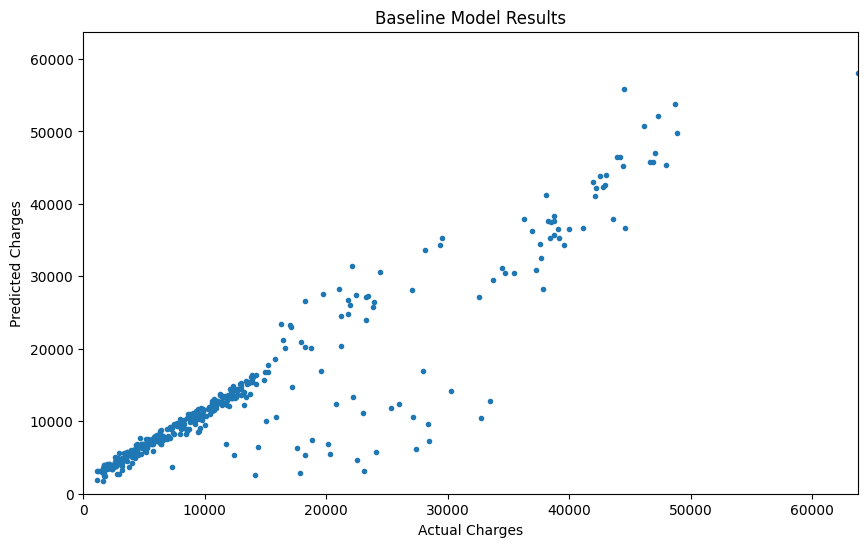

In [41]:
f = plt.figure(figsize=(10,6))
ax = plt.axes()

ax.plot(y_test, linearRegression.predict(X_test),
         marker='o', ls='', ms=3.0)

lim = (0, y_test.max())

ax.set(xlabel='Actual Charges',
       ylabel='Predicted Charges',
       xlim=lim,
       ylim=lim,
       title='Baseline Model Results');

In [42]:
from sklearn.linear_model import LassoCV
alphas = np.geomspace(0.1, 400, 1000)
lassoCV = LassoCV(alphas=alphas,
                  max_iter=10000,
                  cv=3).fit(X_train, y_train)

lassoCV_rmse = rmse(y_test, lassoCV.predict(X_test))
lassoCV_R2 = r2_score(y_test, lassoCV.predict(X_test))

print(lassoCV.alpha_, lassoCV_rmse)  # Lasso is slower
print(lassoCV_R2)
13.7454744402372

13.7454744402372 4496.577651935266
0.8621019197275019


13.7454744402372

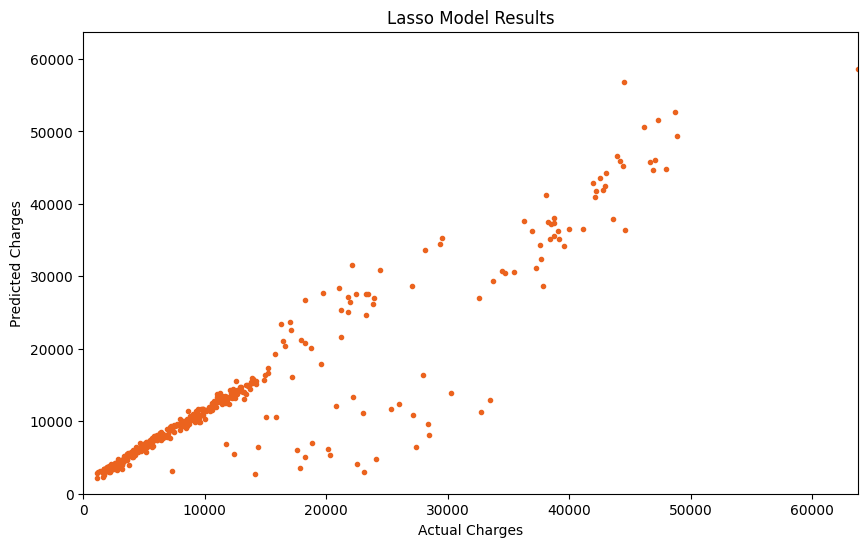

In [43]:
f = plt.figure(figsize=(10,6))
ax = plt.axes()

ax.plot(y_test, lassoCV.predict(X_test),
         marker='o', ls='', color='#eb631e', ms=3.0)

lim = (0, y_test.max())

ax.set(xlabel='Actual Charges',
       ylabel='Predicted Charges',
       xlim=lim,
       ylim=lim,
       title='Lasso Model Results');

In [44]:
from sklearn.linear_model import RidgeCV

alphas = np.geomspace(0.01, 20, 1000).tolist()
ridgeCV = RidgeCV(alphas=alphas, cv=3).fit(X_train, y_train)

ridgeCV_rmse = rmse(y_test, ridgeCV.predict(X_test))
ridgeCV_R2 = r2_score(y_test, ridgeCV.predict(X_test))

print(ridgeCV.alpha_, ridgeCV_rmse)
print(ridgeCV_R2)

0.5597483996302115 4494.682979659044
0.8622181043662678


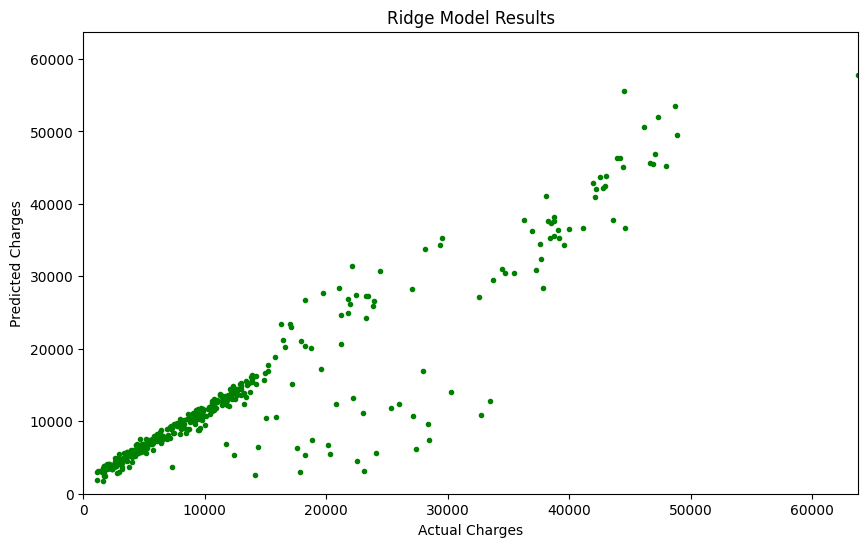

In [45]:
f = plt.figure(figsize=(10,6))
ax = plt.axes()

ax.plot(y_test, ridgeCV.predict(X_test),
         marker='o', ls='', color='g', ms=3.0)

lim = (0, y_test.max())

ax.set(xlabel='Actual Charges',
       ylabel='Predicted Charges',
       xlim=lim,
       ylim=lim,
       title='Ridge Model Results');

In [47]:
from sklearn.linear_model import ElasticNetCV
alphas = np.geomspace(0.001, 1, 100)
l1_ratios = np.linspace(0.1, 0.9, 10)

elasticNetCV = ElasticNetCV(alphas=alphas,
                            l1_ratio=l1_ratios,
                            max_iter=10000).fit(X_train, y_train)

elasticNetCV_rmse = rmse(y_test, elasticNetCV.predict(X_test))
elasticNetCV_R2 = r2_score(y_test, elasticNetCV.predict(X_test))

print(elasticNetCV.alpha_, elasticNetCV.l1_ratio_, elasticNetCV_rmse)
print(ridgeCV_R2)

0.008111308307896872 0.9 4494.417700642735
0.8622181043662678


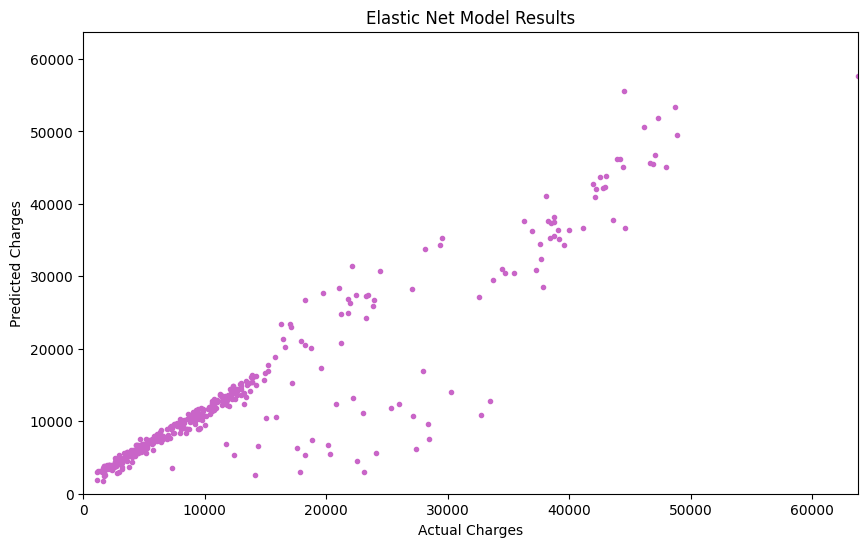

In [48]:
f = plt.figure(figsize=(10,6))
ax = plt.axes()

ax.plot(y_test, elasticNetCV.predict(X_test),
         marker='o', ls='', color='#c965c8', ms=3.0)

lim = (0, y_test.max())

ax.set(xlabel='Actual Charges',
       ylabel='Predicted Charges',
       xlim=lim,
       ylim=lim,
       title='Elastic Net Model Results');

In [49]:
rmse_vals = [linearRegression_rmse, lassoCV_rmse, ridgeCV_rmse, elasticNetCV_rmse]
R2_vals = [linearRegression_R2, lassoCV_R2, ridgeCV_R2, elasticNetCV_R2]

labels = ['Linear', 'Lasso', 'Ridge', 'ElasticNet']
metric_df = pd.Series(rmse_vals, index=labels).to_frame()
metric_df.rename(columns={0: 'RMSE'}, inplace=1)
metric_df['R2'] = R2_vals
metric_df

,RMSE,R2
Linear,4496.560111,0.862103
Lasso,4496.577652,0.862102
Ridge,4494.682980,0.862218
ElasticNet,4494.417701,0.862234


In [51]:
# Import SGDRegressor and prepare the parameters

from sklearn.linear_model import SGDRegressor

model_parameters_dict = {
    'Linear': {'penalty': None},
    'Lasso': {'penalty': 'l1',
           'alpha': lassoCV.alpha_},
    'Ridge': {'penalty': 'l2', # Changed penalty to 'l2' for Ridge-like behavior with SGD
           'alpha': ridgeCV.alpha_}, # Using ridgeCV.alpha_ for Ridge penalty
    'ElasticNet': {'penalty': 'elasticnet',
                   'alpha': elasticNetCV.alpha_,
                   'l1_ratio': elasticNetCV.l1_ratio_}
}

new_rmses = {}
new_R2 = {}
for modellabel, parameters in model_parameters_dict.items():
    # following notation passes the dict items as arguments
    SGD = SGDRegressor(**parameters)
    SGD.fit(X_train, y_train)
    new_rmses[modellabel] = rmse(y_test, SGD.predict(X_test))
    new_R2[modellabel] = r2_score(y_test, SGD.predict(X_test))

metric_df['RMSE-SGD'] = pd.Series(new_rmses)
metric_df['R2-SGD'] = pd.Series(new_R2)
metric_df

,RMSE,R2,RMSE-SGD,R2-SGD
Linear,4496.560111,0.862103,4522.030279,0.860536
Lasso,4496.577652,0.862102,4537.899105,0.859556
Ridge,4494.682980,0.862218,5645.004654,0.782669
ElasticNet,4494.417701,0.862234,4518.357346,0.860763
